In [166]:
# !pip install seaborn


In [167]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stats

# Import data
- all thresholds: df_both_sessions

In [168]:
df_both_sessions = pd.read_csv('tidy_both_sessions_thresholds.csv')

In [169]:
num_thresholds_per_subj = 18
assert df_both_sessions["prolificID"].nunique() == len(df_both_sessions) / num_thresholds_per_subj, 'Fatal: Number of thresholds per subject does not match'

print(f'\nNumber of participants with both sessions: {df_both_sessions["prolificID"].nunique()}')


Number of participants with both sessions: 169


In [170]:
print(df_both_sessions.columns)

Index(['prolificID', 'conditionName', 'taskName', 'meridian', 'repeat',
       'threshold', 'numTrialsSent', 'questSD', 'readingCQAccuracy'],
      dtype='object')


In [171]:
display(df_both_sessions.head())

,prolificID,conditionName,taskName,meridian,repeat,threshold,numTrialsSent,questSD,readingCQAccuracy
0,5f0788c06b220f03231666a0,crowding_R8_block1,crowding,R8,1,1.106513,36.0,0.065508,NaN
1,5f0788c06b220f03231666a0,crowding_L8_block1,crowding,L8,1,1.510901,36.0,0.050216,NaN
2,5f0788c06b220f03231666a0,crowding_R8_block2,crowding,R8,2,0.746883,36.0,0.051141,NaN
3,5f0788c06b220f03231666a0,crowding_L8_block2,crowding,L8,2,1.948321,37.0,0.058716,NaN
4,5f0788c06b220f03231666a0,acuity_R8_block1,acuity,R8,1,0.337192,36.0,0.048382,NaN


# Data cleaning

## Filter participants based on the quality of individual thresholds
Exclude participants with:
- acuity and crowding: numTrialsSent < 35, questSD > 0.1
- rsvp: numTrialsSent < 24, questSD > 0.1
- ordinary reading: accuracy < 60

Outputs: prolificID of participants excluded based on each criteria. 
- {taskName}_low_trial_ids
- {taskName}_large_questSD_ids
- reading_low_accuracy_ids

In [172]:
acuity_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["numTrialsSent"] < 35),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < 35: {len(acuity_low_trial_ids)}')

acuity_large_questSD_ids = (
	df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["acuity"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
	]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(acuity_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 35: 16
Number of participants with at least 1 threshold with questSD > 0.1: 3


In [173]:
crowding_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["numTrialsSent"] < 35),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < 35: {len(crowding_low_trial_ids)}')

crowding_large_questSD_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["crowding"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(crowding_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 35: 22
Number of participants with at least 1 threshold with questSD > 0.1: 28


In [174]:
rsvp_low_trial_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["numTrialsSent"] < 24),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with number of trials < 24: {len(rsvp_low_trial_ids)}')

rsvp_large_questSD_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["rsvp"]) & (df_both_sessions["questSD"] > 0.1),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 threshold with questSD > 0.1: {len(rsvp_large_questSD_ids)}')


Number of participants with at least 1 threshold with number of trials < 24: 0
Number of participants with at least 1 threshold with questSD > 0.1: 11


In [175]:
reading_low_accuracy_ids = (
    df_both_sessions.loc[
        df_both_sessions["taskName"].isin(["reading"]) & (df_both_sessions["readingCQAccuracy"] < 60),
        "prolificID"
    ]
    .unique()
)
print(f'Number of participants with at least 1 measurement with accuracy < 60%: {len(reading_low_accuracy_ids)}')


Number of participants with at least 1 measurement with accuracy < 60%: 63


## Compute the geometric mean of thresholds
- within the same block (one threshold per block): df_gmean_block
- across blocks for each task (one threshold per task): df_gmean_task

In [176]:
# Group by participant, task, and repeat
df_gmean_block = (
    df_both_sessions.groupby(["prolificID", "taskName", "repeat"], observed=True)
					.agg(gmean_threshold_block=("threshold", lambda x: stats.gmean(x.dropna())))
					.reset_index()
)
df_gmean_block

,prolificID,taskName,repeat,gmean_threshold_block
0,559ad287fdf99b219a612d22,acuity,1,0.384426
1,559ad287fdf99b219a612d22,acuity,2,0.330667
2,559ad287fdf99b219a612d22,crowding,1,7.009494
3,559ad287fdf99b219a612d22,crowding,2,7.632362
4,559ad287fdf99b219a612d22,crowding,3,8.919779
...,...,...,...,...
1685,67fffee26ec983c07f3a2abd,crowding,4,1.380877
1686,67fffee26ec983c07f3a2abd,reading,1,126.616278
1687,67fffee26ec983c07f3a2abd,reading,2,190.456737
1688,67fffee26ec983c07f3a2abd,rsvp,1,349.911062


In [177]:
# Group by participant, task, and repeat
df_gmean_task = (
    df_both_sessions.groupby(["prolificID", "taskName"], observed=True)
					.agg(gmean_threshold_task=("threshold", lambda x: stats.gmean(x.dropna())))
					.reset_index()
)
df_gmean_task

,prolificID,taskName,gmean_threshold_task
0,559ad287fdf99b219a612d22,acuity,0.356535
1,559ad287fdf99b219a612d22,crowding,8.508733
2,559ad287fdf99b219a612d22,reading,189.995888
3,559ad287fdf99b219a612d22,rsvp,429.768011
4,55d51a6b8ce09000127d4821,acuity,0.232416
...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,1499.128389
672,67fffee26ec983c07f3a2abd,acuity,0.333686
673,67fffee26ec983c07f3a2abd,crowding,2.253967
674,67fffee26ec983c07f3a2abd,reading,155.289804


## Filter participants based on test-retest ratio
- log(test/retest), i.e., log(test) - log(retest), note: not the ratio of the logged thresholds; take the ratio between the numerical thresholds and then take the log.
- if test and retest are very different, then it means that the participant is unreliable and therefore should be excluded 

Outputs: prolificID of participants with large test-retest ratio
- {taskName}_bad_ratio_ids

### Functions:

In [178]:
def compute_test_retest_ratio(df, block1_colname, block2_colname):
	'''
	Compute test-retest ratio: log10(block2 / block1)
	'''
	return np.log10(df[block2_colname] / df[block1_colname])

def flag_outliers_IQR(
    df,
    col_prefix="log_ratio_",
    iqr_k=1.5,
    add_block_flags=True,
    verbose=True,
):
    """
    Add boolean outlier flags using the IQR rule to ratio columns in a pivot table.

    - Detects columns via `col_prefix`.
    - For each ratio col: computes Q1, Q3, IQR; flags values < Q1 - k*IQR or > Q3 + k*IQR.
    - Writes a boolean flag column '<ratio_col>_is_outlier'.
    Returns a new DataFrame (does not modify input).
    """
    df = df.copy()

    # Identify ratio columns
    colNames = [c for c in df.columns if c.startswith(col_prefix)]

    for col in colNames:
        # Compute IQR bounds (NaNs ignored by quantile)
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_k * iqr
        upper = q3 + iqr_k * iqr

        mask = (df[col] < lower) | (df[col] > upper)
        out_col = f"{col}_is_outlier"
        df[out_col] = mask.fillna(False)

        if verbose:
            n = int(mask.sum())
            print(f"{col}: Q1={q1:.4f}, Q3={q3:.4f}, IQR={iqr:.4f}, "
                  f"bounds=({lower:.4f}, {upper:.4f}), outliers={n}")

    return df


def exclusion_ids_from_flags(
    df_wide: pd.DataFrame,
    task: str,
    flag_cols=None,                 # e.g., ["log_ratio_2vs1_is_outlier"] or None → auto-pick all *_is_outlier
    require="any",                  # "any" = exclude if ANY flag True; "all" = exclude only if ALL flags True
):
    """
    Return a list of prolificID to exclude for a given task, based on boolean outlier flags.
    df_wide must include columns: 'prolificID', 'taskName', and *_is_outlier booleans.
    """
    d = df_wide[df_wide["taskName"] == task]

    if flag_cols is None:
        flag_cols = [c for c in d.columns if c.endswith("_is_outlier")]

    if not flag_cols:
        return []  # nothing to check

    by_id = d.groupby("prolificID")[flag_cols]
    if require == "any":
        bad = d.groupby("prolificID")[flag_cols].any().any(axis=1)
    elif require == "all":
        bad = d.groupby("prolificID")[flag_cols].all().all(axis=1)
    else:
        raise ValueError("Invalid require value. Use 'any' or 'all'.")
    return bad[bad].index.tolist()

def filter_excluding_ids(df_wide: pd.DataFrame, *exclude_lists):
    """
    Return df_wide with rows whose prolificID is NOT in any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    exclude_ids = set().union(*exclude_lists)
    return df_wide[~df_wide["prolificID"].isin(exclude_ids)].copy()

def filter_including_ids(df_wide: pd.DataFrame, *include_lists):
    """
    Return df_wide with rows whose prolificID IS IN any of the exclude lists.
    Accepts multiple lists/sets of IDs.
    """
    # Merge all input lists/sets into one set
    include_ids = set().union(*include_lists)
    return df_wide[df_wide["prolificID"].isin(include_ids)].copy()


In [179]:
def plot_ratio(data_array, title, num_bins=80, min_val=-2.5, max_val=2.5, abs_bool=False): # , num_bins=20, min_val=0.08, max_val=1.11
    '''
    Input:
    - data_array: an array of test-retest ratios
    - title: [string] title and x-axis label of the figure
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    bins = np.linspace(min_val, max_val, num_bins + 1)
    if abs_bool:
        data_array = np.abs(data_array)
        title = 'Absolute ' + title
                
    plt.figure(figsize=(8, 2)) 
    plt.hist(data_array, bins=bins, color='lightyellow', edgecolor='black')# bins=bins
    plt.title(f"{title} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)
    plt.xlabel(title, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xlim(min_val, max_val)
    # plt.ylim(0,100)
    # add ticks and format them as normal floats
    # tick_positions = np.linspace(0.1, 1, num=10)  
    # plt.xticks(tick_positions, labels=[f"{x:.1f}" for x in tick_positions])

    
    plt.show()

### Compute ratios:

In [180]:
df_gmean_block_wide = (df_gmean_block
        .pivot(index=["prolificID", "taskName"],
               columns="repeat",
               values="gmean_threshold_block")
        .rename(columns={1: "block1", 2: "block2", 3: "block3", 4: "block4"})
        .reset_index())

df_gmean_block_wide

repeat,prolificID,taskName,block1,block2,block3,block4
0,559ad287fdf99b219a612d22,acuity,0.384426,0.330667,NaN,NaN
1,559ad287fdf99b219a612d22,crowding,7.009494,7.632362,8.919779,10.983982
2,559ad287fdf99b219a612d22,reading,210.134765,171.787079,NaN,NaN
3,559ad287fdf99b219a612d22,rsvp,333.871474,553.208518,NaN,NaN
4,55d51a6b8ce09000127d4821,acuity,0.253129,0.213398,NaN,NaN
...,...,...,...,...,...,...
671,67e461f383bb0fc948ffd5fd,rsvp,1549.108459,1450.760864,NaN,NaN
672,67fffee26ec983c07f3a2abd,acuity,0.399892,0.278440,NaN,NaN
673,67fffee26ec983c07f3a2abd,crowding,3.404956,4.280694,1.282359,1.380877
674,67fffee26ec983c07f3a2abd,reading,126.616278,190.456737,NaN,NaN


In [181]:
df_gmean_block_wide['log_ratio_2vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block2')
df_gmean_block_wide['log_ratio_3vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block3')
df_gmean_block_wide['log_ratio_4vs1'] = compute_test_retest_ratio(df_gmean_block_wide, 'block1', 'block4')
df_gmean_block_wide['log_ratio_3vs2'] = compute_test_retest_ratio(df_gmean_block_wide, 'block2', 'block3')
df_gmean_block_wide['log_ratio_4vs2'] = compute_test_retest_ratio(df_gmean_block_wide, 'block2', 'block4')
df_gmean_block_wide['log_ratio_4vs3'] = compute_test_retest_ratio(df_gmean_block_wide, 'block3', 'block4')

In [182]:
display(df_gmean_block_wide.head())

repeat,prolificID,taskName,block1,block2,block3,block4,log_ratio_2vs1,log_ratio_3vs1,log_ratio_4vs1,log_ratio_3vs2,log_ratio_4vs2,log_ratio_4vs3
0,559ad287fdf99b219a612d22,acuity,0.384426,0.330667,NaN,NaN,-0.065422,NaN,NaN,NaN,NaN,NaN
1,559ad287fdf99b219a612d22,crowding,7.009494,7.632362,8.919779,10.983982,0.036972,0.104667,0.195073,0.067695,0.158101,0.090406
2,559ad287fdf99b219a612d22,reading,210.134765,171.787079,NaN,NaN,-0.087507,NaN,NaN,NaN,NaN,NaN
3,559ad287fdf99b219a612d22,rsvp,333.871474,553.208518,NaN,NaN,0.219310,NaN,NaN,NaN,NaN,NaN
4,55d51a6b8ce09000127d4821,acuity,0.253129,0.213398,NaN,NaN,-0.074150,NaN,NaN,NaN,NaN,NaN


### Plot ratios before filtering

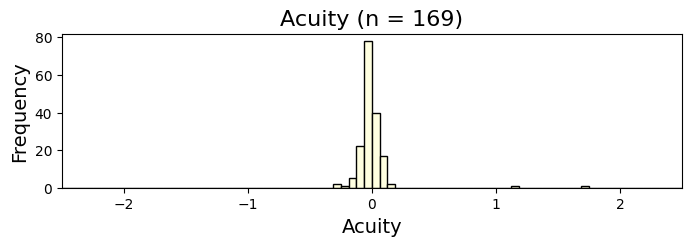

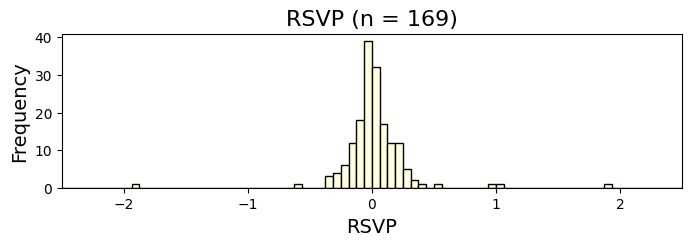

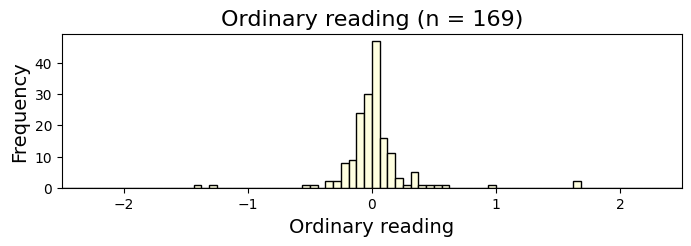

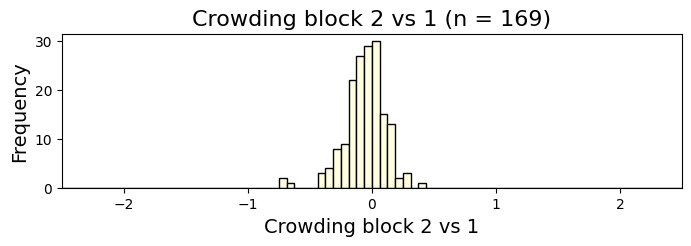

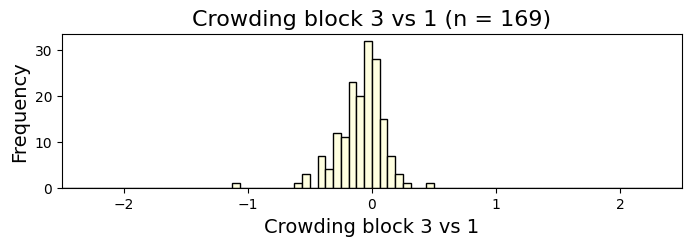

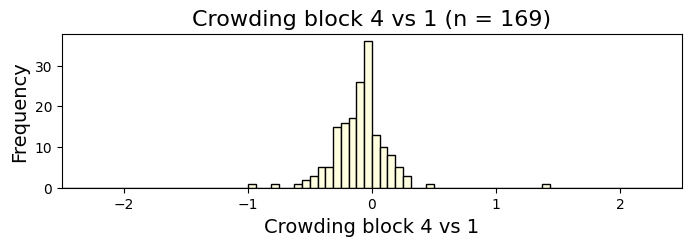

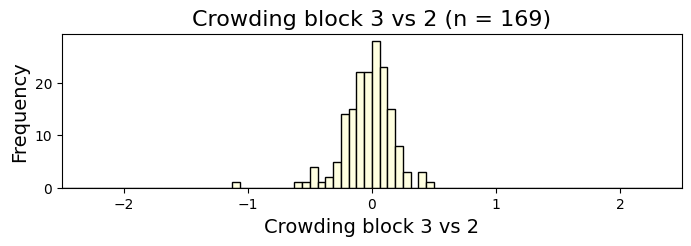

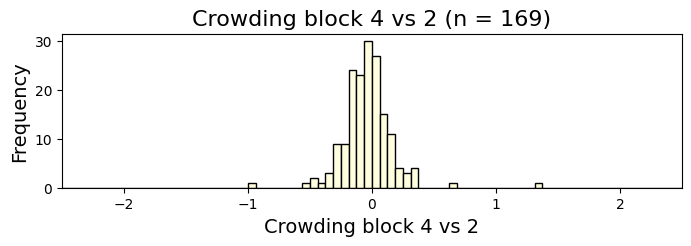

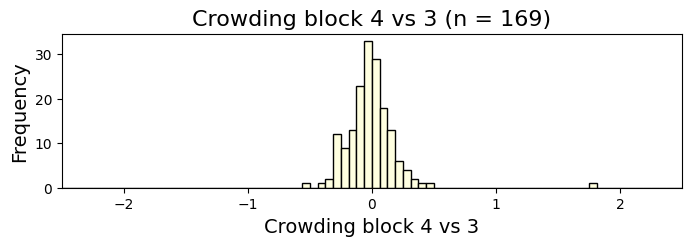

In [183]:
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "acuity"]['log_ratio_2vs1'], 'Acuity')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "rsvp"]['log_ratio_2vs1'], 'RSVP')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "reading"]['log_ratio_2vs1'], 'Ordinary reading')

plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_2vs1'], 'Crowding block 2 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_3vs1'], 'Crowding block 3 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs1'], 'Crowding block 4 vs 1')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_3vs2'], 'Crowding block 3 vs 2')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs2'], 'Crowding block 4 vs 2')
plot_ratio(df_gmean_block_wide[df_gmean_block_wide["taskName"] == "crowding"]['log_ratio_4vs3'], 'Crowding block 4 vs 3')


### Flag outliers

In [184]:
df_gmean_block_wide_flaggedOutliers = df_gmean_block_wide.copy()
df_gmean_block_wide_flaggedOutliers = flag_outliers_IQR(df_gmean_block_wide_flaggedOutliers)

log_ratio_2vs1: Q1=-0.0792, Q3=0.0543, IQR=0.1335, bounds=(-0.2794, 0.2545), outliers=59
log_ratio_3vs1: Q1=-0.1719, Q3=0.0235, IQR=0.1954, bounds=(-0.4650, 0.3166), outliers=6
log_ratio_4vs1: Q1=-0.2062, Q3=-0.0020, IQR=0.2042, bounds=(-0.5126, 0.3043), outliers=6
log_ratio_3vs2: Q1=-0.1309, Q3=0.0897, IQR=0.2206, bounds=(-0.4618, 0.4206), outliers=7
log_ratio_4vs2: Q1=-0.1476, Q3=0.0505, IQR=0.1981, bounds=(-0.4447, 0.3477), outliers=6
log_ratio_4vs3: Q1=-0.1099, Q3=0.0722, IQR=0.1822, bounds=(-0.3832, 0.3454), outliers=5


In [185]:
display(df_gmean_block_wide_flaggedOutliers.head())

repeat,prolificID,taskName,block1,block2,block3,block4,log_ratio_2vs1,log_ratio_3vs1,log_ratio_4vs1,log_ratio_3vs2,log_ratio_4vs2,log_ratio_4vs3,log_ratio_2vs1_is_outlier,log_ratio_3vs1_is_outlier,log_ratio_4vs1_is_outlier,log_ratio_3vs2_is_outlier,log_ratio_4vs2_is_outlier,log_ratio_4vs3_is_outlier
0,559ad287fdf99b219a612d22,acuity,0.384426,0.330667,NaN,NaN,-0.065422,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
1,559ad287fdf99b219a612d22,crowding,7.009494,7.632362,8.919779,10.983982,0.036972,0.104667,0.195073,0.067695,0.158101,0.090406,False,False,False,False,False,False
2,559ad287fdf99b219a612d22,reading,210.134765,171.787079,NaN,NaN,-0.087507,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
3,559ad287fdf99b219a612d22,rsvp,333.871474,553.208518,NaN,NaN,0.219310,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False
4,55d51a6b8ce09000127d4821,acuity,0.253129,0.213398,NaN,NaN,-0.074150,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False


### List participants filtered out by test-retest ratios

In [186]:
# exclude all participants with any outlier in any of the crowding ratios
acuity_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='acuity', flag_cols=["log_ratio_2vs1_is_outlier"])
crowding_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding')
rsvp_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='rsvp', flag_cols=["log_ratio_2vs1_is_outlier"])
reading_bad_ratio_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='reading', flag_cols=["log_ratio_2vs1_is_outlier"])

df_all_acuity = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "acuity"]
df_filtered_acuity = filter_excluding_ids(df_all_acuity, acuity_bad_ratio_ids)

df_all_rsvp = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "rsvp"]
df_filtered_rsvp = filter_excluding_ids(df_all_rsvp, rsvp_bad_ratio_ids)

df_all_reading = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "reading"]
df_filtered_reading = filter_excluding_ids(df_all_reading, reading_bad_ratio_ids)

# Below are exclusiong ids for individual crowding ratios. Created for plotting ratios after exclusion.
crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_2vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding21 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_3vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding31 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs1_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding41 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_3vs2_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding32 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs2_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding42 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)

crowding_exclude_ids = exclusion_ids_from_flags(df_gmean_block_wide_flaggedOutliers, task='crowding', flag_cols=["log_ratio_4vs3_is_outlier"])
df_all_crowding = df_gmean_block_wide_flaggedOutliers[df_gmean_block_wide_flaggedOutliers["taskName"] == "crowding"]
df_filtered_crowding43 = filter_excluding_ids(df_all_crowding, crowding_exclude_ids)


### Plot ratios after filtering

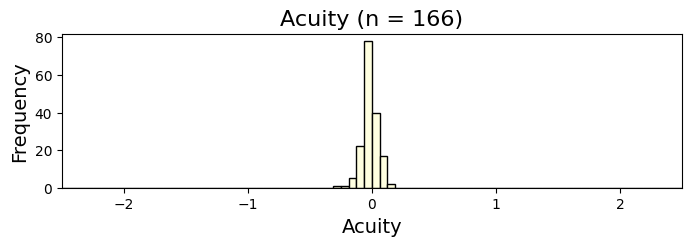

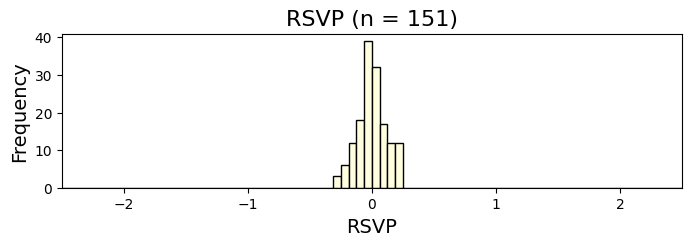

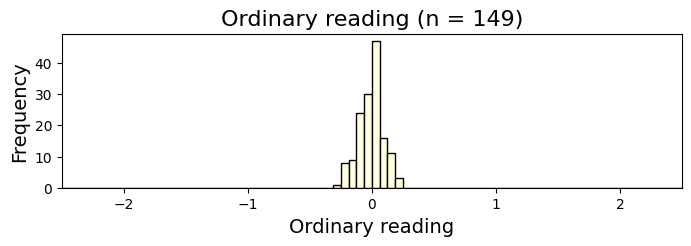

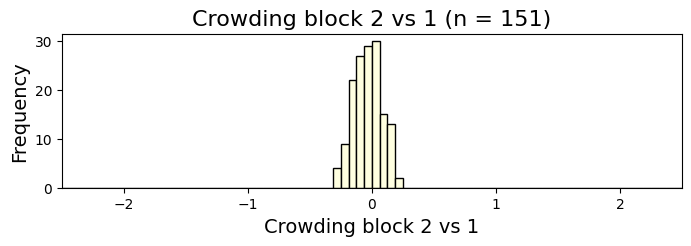

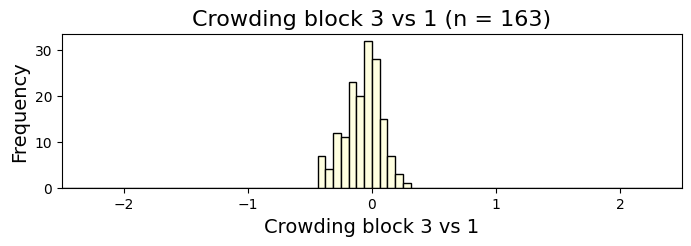

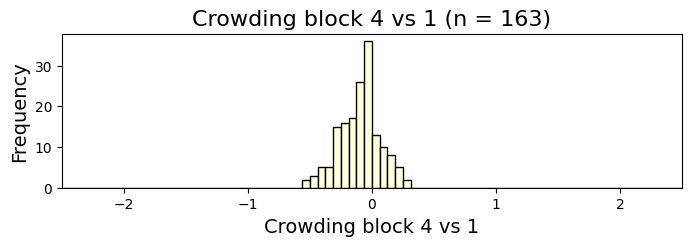

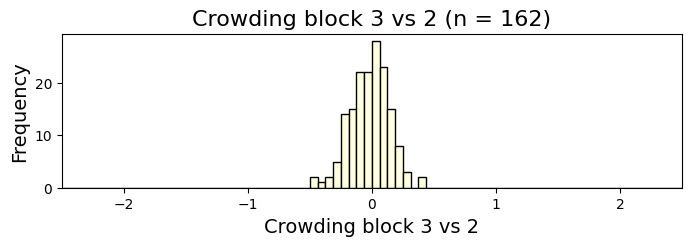

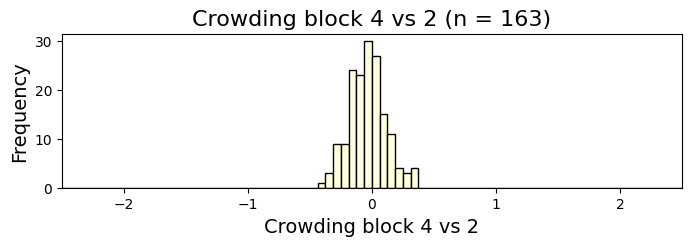

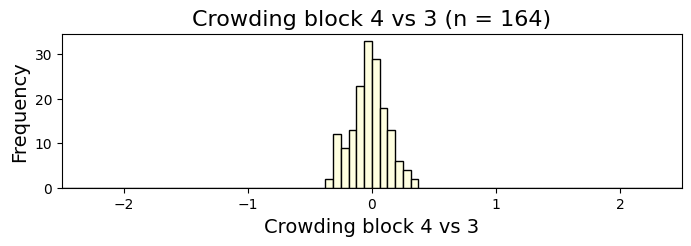

In [187]:
plot_ratio(df_filtered_acuity["log_ratio_2vs1"],title="Acuity")
plot_ratio(df_filtered_rsvp["log_ratio_2vs1"], title="RSVP")
plot_ratio(df_filtered_reading["log_ratio_2vs1"], title="Ordinary reading")

plot_ratio(df_filtered_crowding21["log_ratio_2vs1"], title="Crowding block 2 vs 1")
plot_ratio(df_filtered_crowding31["log_ratio_3vs1"], title="Crowding block 3 vs 1")
plot_ratio(df_filtered_crowding41["log_ratio_4vs1"], title="Crowding block 4 vs 1")
plot_ratio(df_filtered_crowding32["log_ratio_3vs2"], title="Crowding block 3 vs 2")
plot_ratio(df_filtered_crowding42["log_ratio_4vs2"], title="Crowding block 4 vs 2")
plot_ratio(df_filtered_crowding43["log_ratio_4vs3"], title="Crowding block 4 vs 3")

# Histograms of cleaned data

### Functions:

In [188]:
def plot_threshold_array(data_array, threshold_name, plot_log_scale=True, hist_color='skyblue', name_sd_bool=True,
                         num_bins=50, min_val=0.08, max_val=1.11, plot_JOV_patch=False):
    '''
    Input:
    - data_array: an array of data (could be output from extract_all_thresholds)
    - threshold_name: [string] title and x-axis label of the figure
    - plot_JOV_patch: [bool] plots mean +- 1 sd from crowding data (Kurzawski, Burchell et al., 2023, JOV) 
    '''
    
    # make the bins look the same size on a log scale
    # min_val = round(np.nanmin(data_array),2)
    # max_val = round(np.nanmax(data_array),2)
    # print(f'Min and max bin limits: {min_val}, {max_val}')
    
    std_data_array = np.nanstd(data_array)


    if plot_log_scale:
        bins = np.logspace(np.log10(min_val), np.log10(max_val), num_bins + 1)
    else:
        bins = np.linspace(min_val, max_val, num_bins + 1)
    
    plt.figure(figsize=(8, 2)) 

    if plot_JOV_patch:
        lowerBound = 0.18
        upperBound = 0.41
        plt.axvspan(lowerBound, upperBound, color='lightgray', alpha=0.5) # mean +- one std
    
    if name_sd_bool:
        plt.title(f"{threshold_name} (n = {np.count_nonzero(~np.isnan(data_array))}, sd = {round(std_data_array, 2)})", fontsize = 16)
    else:
        plt.title(f"{threshold_name} (n = {np.count_nonzero(~np.isnan(data_array))})", fontsize = 16)

    plt.hist(data_array, bins=bins, color=hist_color, edgecolor='black')# bins=bins
    plt.xlabel(threshold_name, fontsize = 14)
    plt.ylabel("Frequency", fontsize = 14)
    plt.xscale('log') if plot_log_scale else plt.xscale('linear')
    plt.yscale('log')
    plt.ylim(0.5, 200)

    # plt.xlim()
    # plt.ylim()
    # add ticks and format them as normal floats
    # tick_positions = np.logspace(np.log10(min_val), np.log10(max_val), num=10) if plot_log_scale else np.linspace(min_val, max_val, num=10)
    # plt.xticks(tick_positions, labels=[f"{x:.2f}" for x in tick_positions])

    
    plt.show()

In [189]:
def plot_hist_task(df, taskName, y_value,
                    low_trial_ids, large_questSD_ids, bad_ratio_ids, num_bins=50, min_val=0.08, max_val=1.11, bouma_bool=False):
    '''
    Plot histograms for raw data, low trial data, large questSD data, bad ratio data, and cleaned data for a given task.
    '''
    df_task_raw = df[df['taskName'] == taskName]
    df_low_trial = filter_including_ids(df_task_raw, low_trial_ids)
    df_large_questSD = filter_including_ids(df_task_raw, large_questSD_ids)
    df_bad_ratio = filter_including_ids(df_task_raw, bad_ratio_ids)
    df_cleaned = filter_excluding_ids(df_task_raw, low_trial_ids, large_questSD_ids, bad_ratio_ids)

    raw_thresholds = df_task_raw[y_value]
    low_trial_thresholds = df_low_trial[y_value]
    large_questSD_thresholds = df_large_questSD[y_value]
    bad_ratio_thresholds = df_bad_ratio[y_value]
    cleaned_thresholds = df_cleaned[y_value]

    if bouma_bool:
        raw_thresholds = raw_thresholds / 8
        low_trial_thresholds = low_trial_thresholds / 8
        large_questSD_thresholds = large_questSD_thresholds / 8
        bad_ratio_thresholds = bad_ratio_thresholds / 8
        cleaned_thresholds = cleaned_thresholds / 8

    plot_threshold_array(raw_thresholds, f'{taskName} raw', num_bins=num_bins, min_val=min_val, max_val=max_val)
    plot_threshold_array(low_trial_thresholds, f'{taskName} low trials', num_bins=num_bins, min_val=min_val, max_val=max_val, hist_color='plum', name_sd_bool=False)
    plot_threshold_array(large_questSD_thresholds, f'{taskName} large questSD', num_bins=num_bins, min_val=min_val, max_val=max_val, hist_color='plum', name_sd_bool=False)
    plot_threshold_array(bad_ratio_thresholds, f'{taskName} bad test-retest ratio', num_bins=num_bins, min_val=min_val, max_val=max_val, hist_color='plum', name_sd_bool=False)
    plot_threshold_array(cleaned_thresholds, f'{taskName} cleaned', num_bins=num_bins, min_val=min_val, max_val=max_val)

### All individual thresholds:

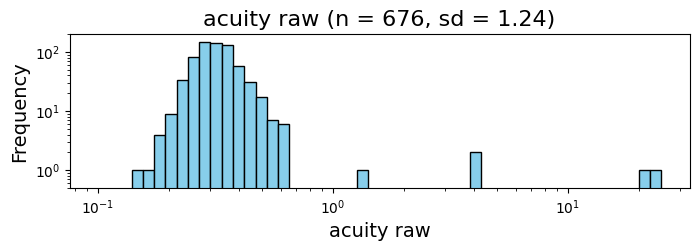

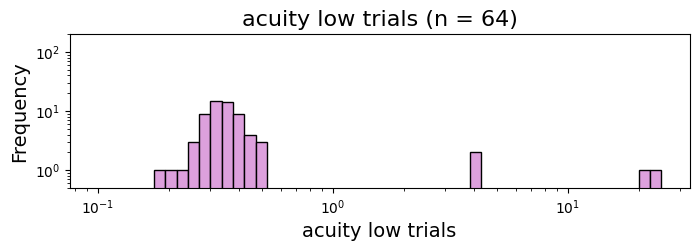

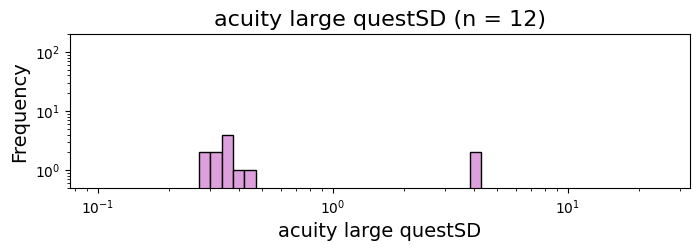

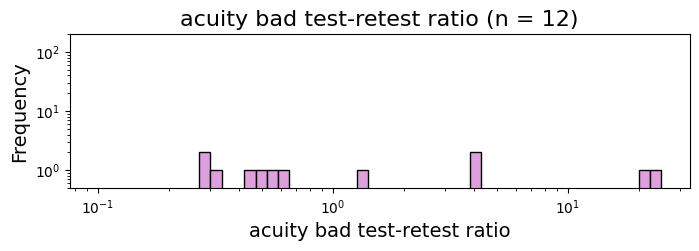

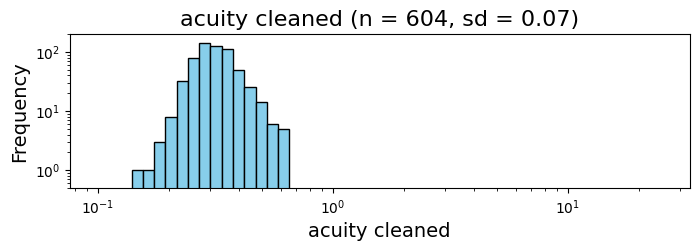

In [190]:
plot_hist_task(df_both_sessions, 'acuity', 'threshold',
                acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids, 
                num_bins=50, min_val=0.1, max_val=25)

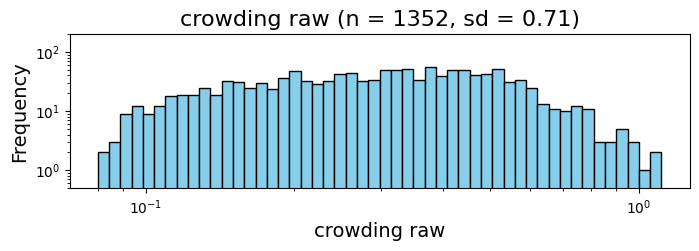

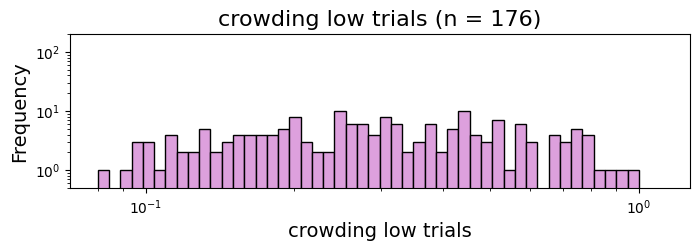

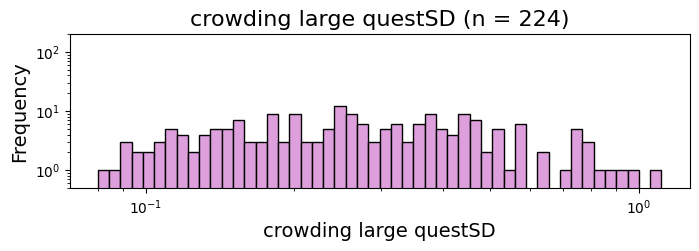

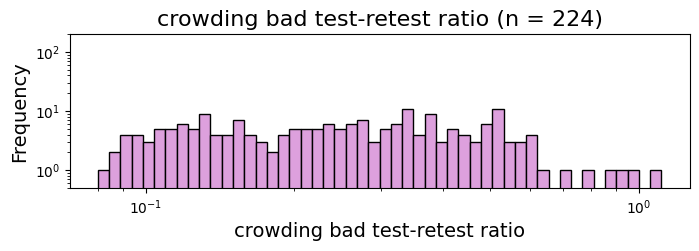

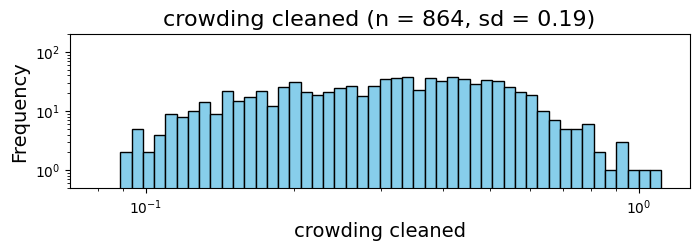

In [191]:
# crowding
plot_hist_task(df_both_sessions, 'crowding', 'threshold',
                crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids, 
                bouma_bool=True)

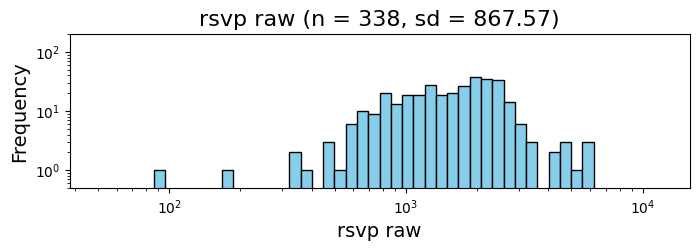

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/cw/__v4n9dd1cl59tk5n02vqjg5lj9bck/T/ipykernel_81560/3367854618.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


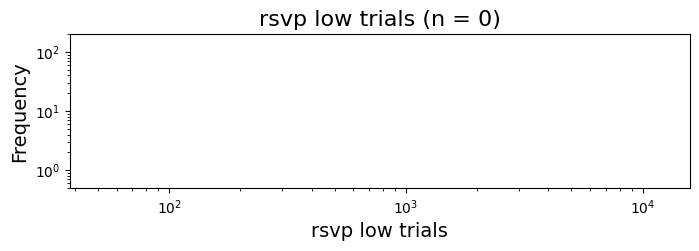

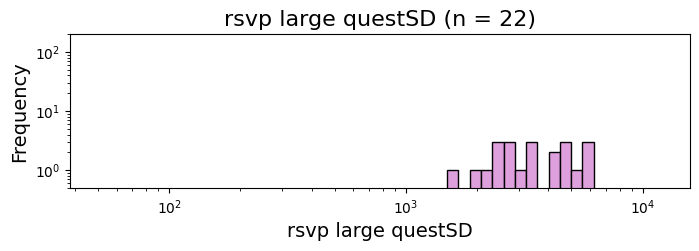

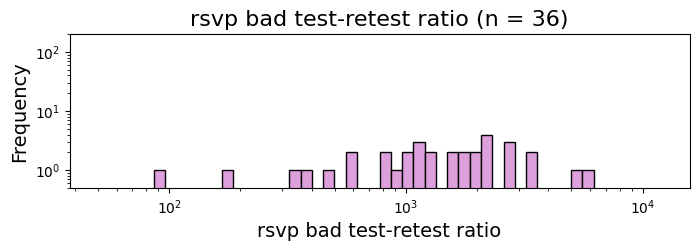

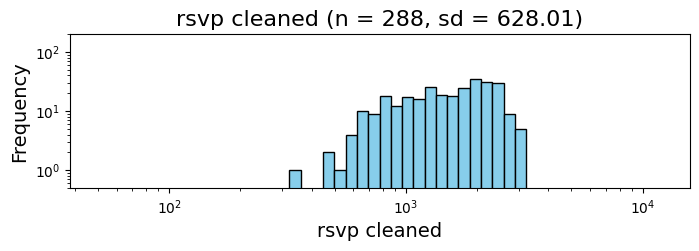

In [192]:
# rsvp
plot_hist_task(df_both_sessions, 'rsvp', 'threshold',
                rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids, 
                num_bins=50, min_val=50, max_val=12000)

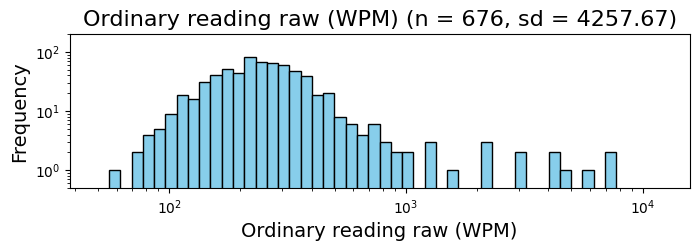

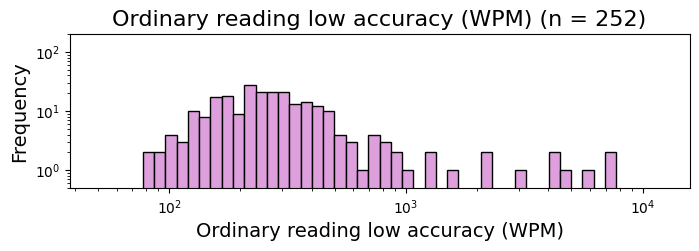

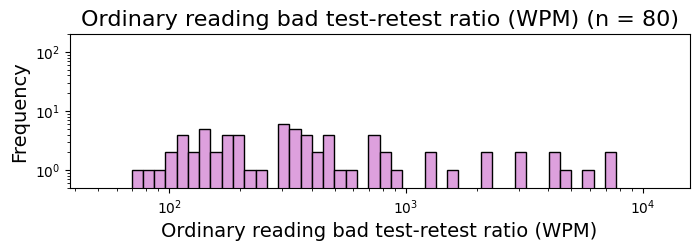

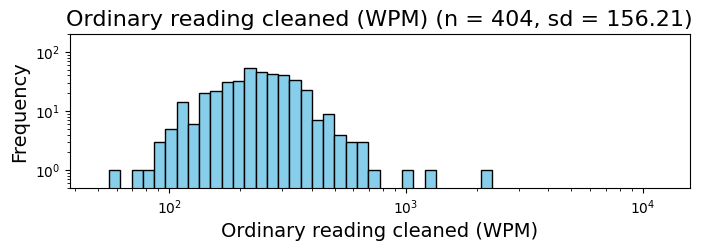

In [193]:
# ordinary reading
df_reading_allThresh_raw = df_both_sessions[df_both_sessions['taskName'] == 'reading']
df_reading_allThresh_low_trial = filter_including_ids(df_reading_allThresh_raw, reading_low_accuracy_ids)
df_reading_allThresh_bad_ratio = filter_including_ids(df_reading_allThresh_raw, reading_bad_ratio_ids)
df_reading_allThresh_cleaned = filter_excluding_ids(df_reading_allThresh_raw, reading_low_accuracy_ids, reading_bad_ratio_ids)

plot_threshold_array(df_reading_allThresh_raw['threshold'], 'Ordinary reading raw (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_allThresh_low_trial['threshold'], 'Ordinary reading low accuracy (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_allThresh_bad_ratio['threshold'], 'Ordinary reading bad test-retest ratio (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_allThresh_cleaned['threshold'], 'Ordinary reading cleaned (WPM)', num_bins=50, min_val=50, max_val=12000)

### Geomean for each block

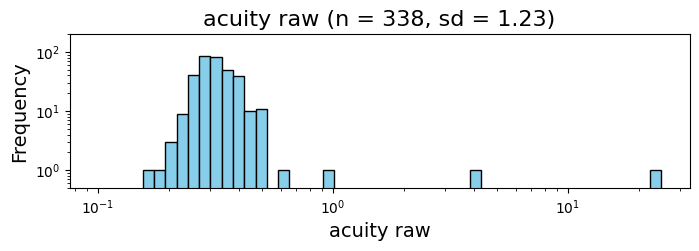

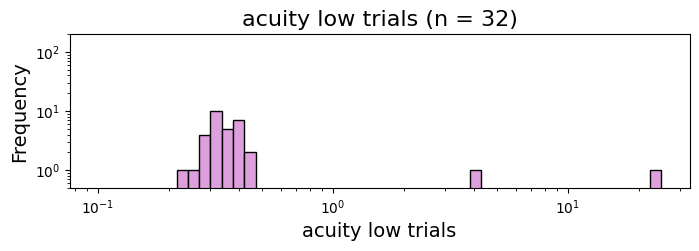

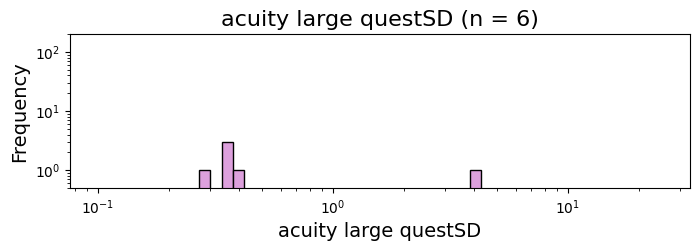

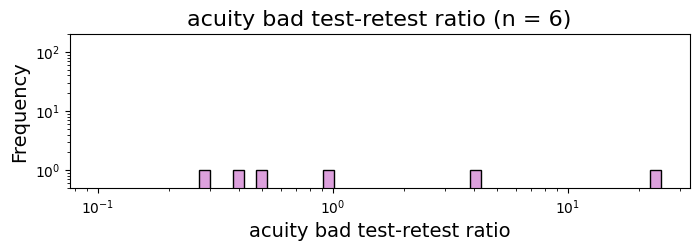

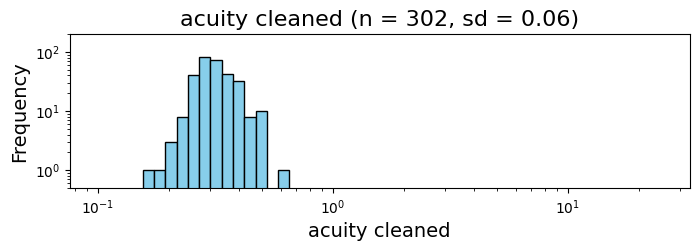

In [194]:
plot_hist_task(df_gmean_block, 'acuity', 'gmean_threshold_block',
                acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids, 
                num_bins=50, min_val=0.1, max_val=25)

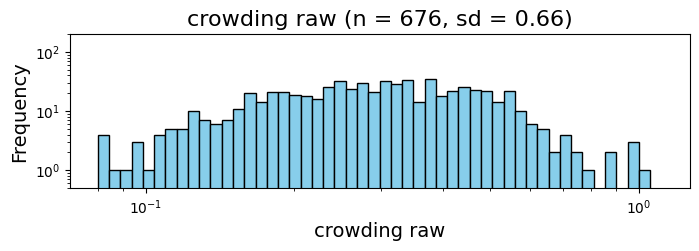

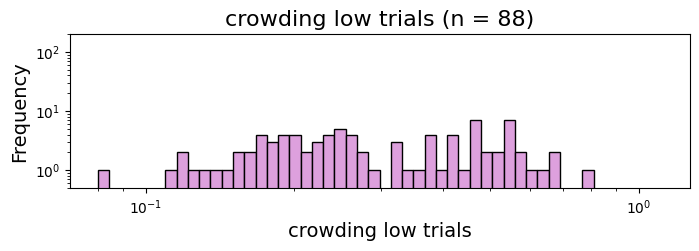

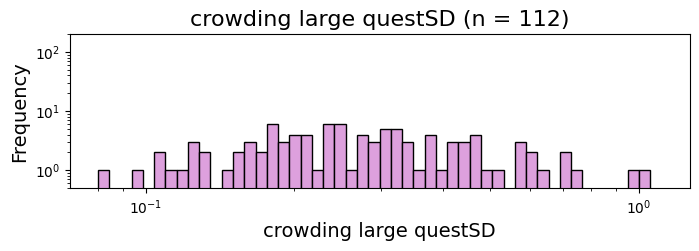

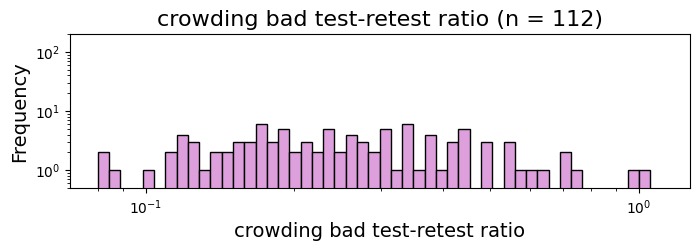

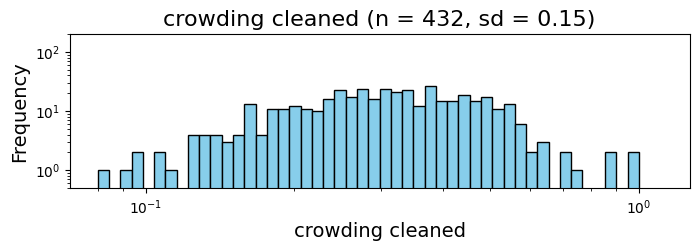

In [195]:
# crowding
plot_hist_task(df_gmean_block, 'crowding', 'gmean_threshold_block',
                crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids, 
                bouma_bool=True)

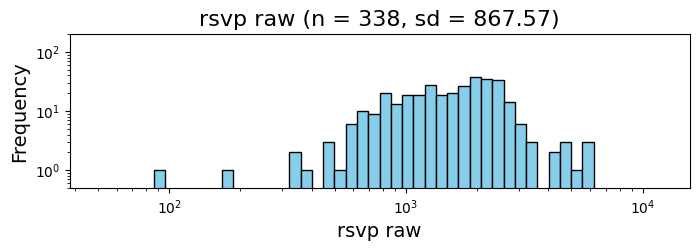

/var/folders/cw/__v4n9dd1cl59tk5n02vqjg5lj9bck/T/ipykernel_81560/3367854618.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


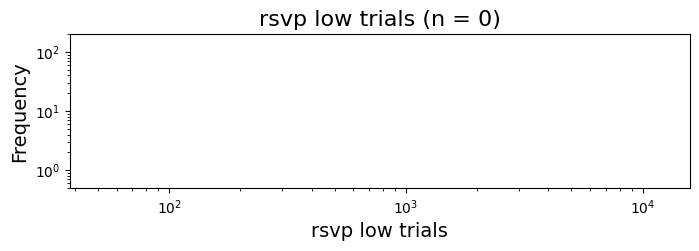

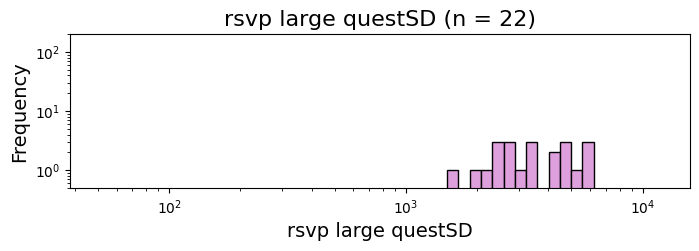

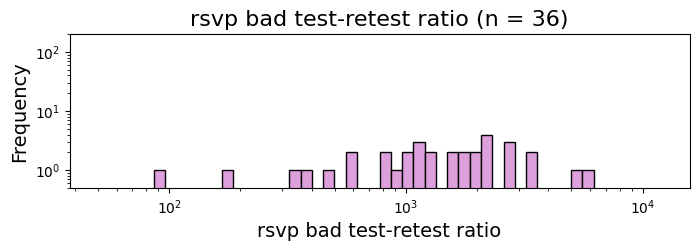

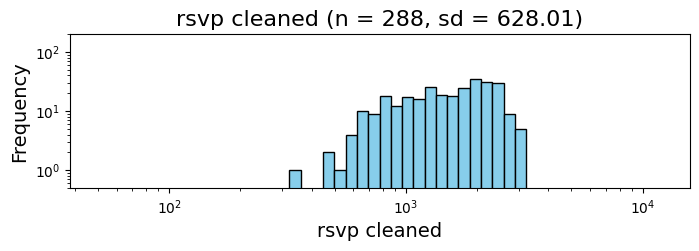

In [196]:
# rsvp
plot_hist_task(df_gmean_block, 'rsvp', 'gmean_threshold_block', 
                rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids, 
                num_bins=50, min_val=50, max_val=12000)

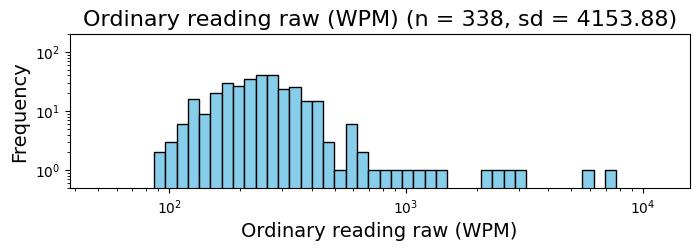

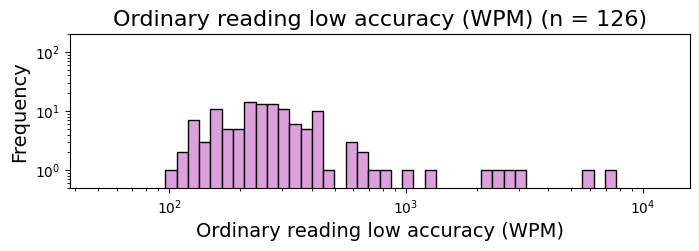

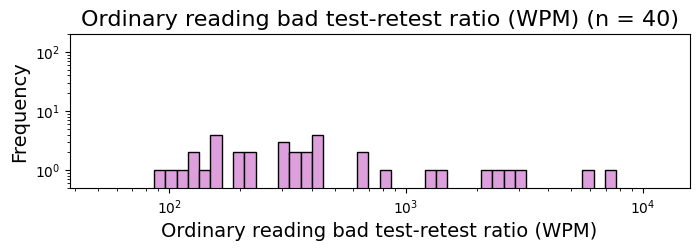

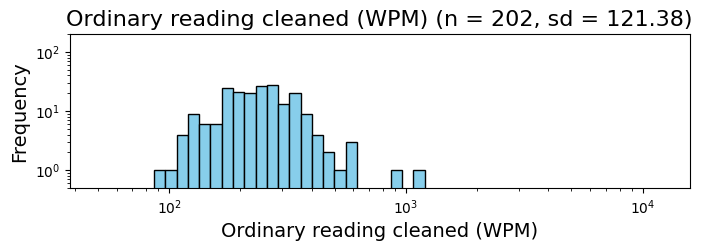

In [197]:
# ordinary reading
df_reading_gmean_block_raw = df_gmean_block[df_gmean_block['taskName'] == 'reading']
df_reading_gmean_block_low_trial = filter_including_ids(df_reading_gmean_block_raw, reading_low_accuracy_ids)
df_reading_gmean_block_bad_ratio = filter_including_ids(df_reading_gmean_block_raw, reading_bad_ratio_ids)
df_reading_gmean_block_cleaned = filter_excluding_ids(df_reading_gmean_block_raw, reading_low_accuracy_ids, reading_bad_ratio_ids)

plot_threshold_array(df_reading_gmean_block_raw['gmean_threshold_block'], 'Ordinary reading raw (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_gmean_block_low_trial['gmean_threshold_block'], 'Ordinary reading low accuracy (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_block_bad_ratio['gmean_threshold_block'], 'Ordinary reading bad test-retest ratio (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_block_cleaned['gmean_threshold_block'], 'Ordinary reading cleaned (WPM)', num_bins=50, min_val=50, max_val=12000)

### Geomean for each task:

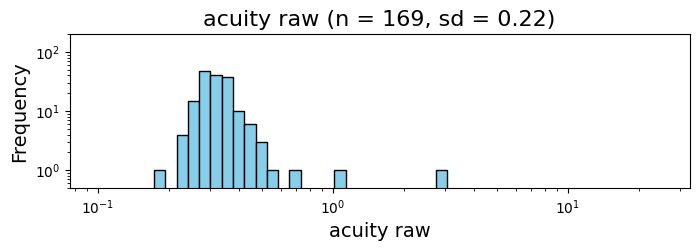

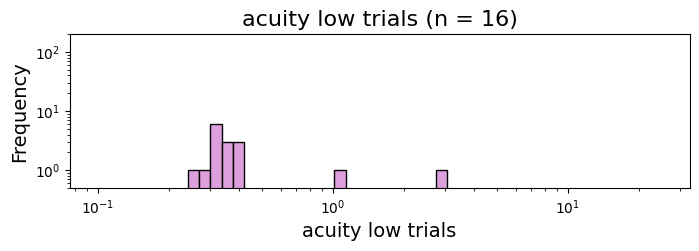

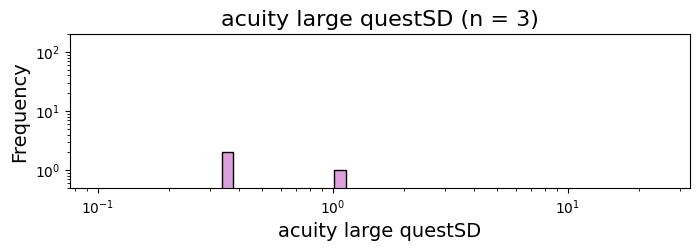

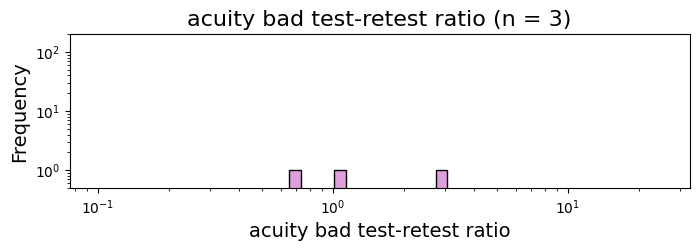

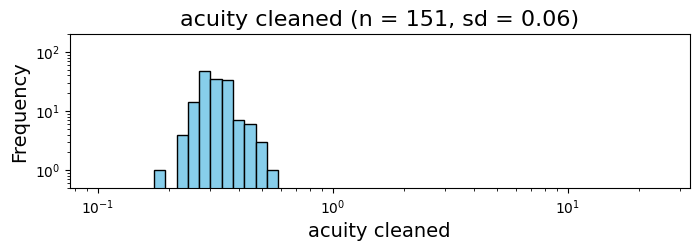

In [198]:
plot_hist_task(df_gmean_task, 'acuity', 'gmean_threshold_task',
                acuity_low_trial_ids, acuity_large_questSD_ids, acuity_bad_ratio_ids, 
                num_bins=50, min_val=0.1, max_val=25)

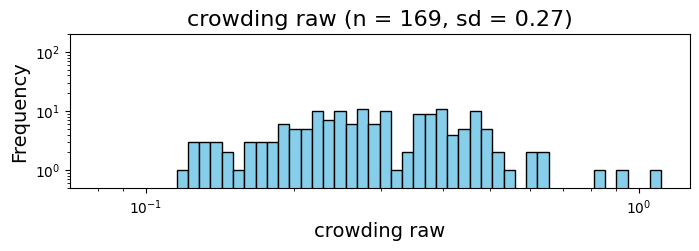

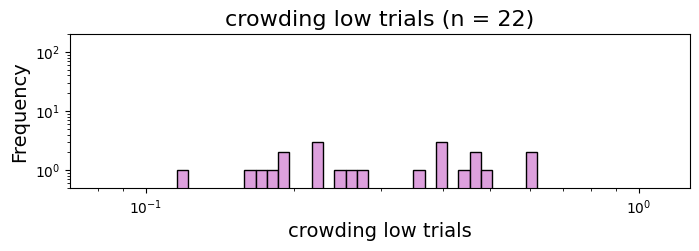

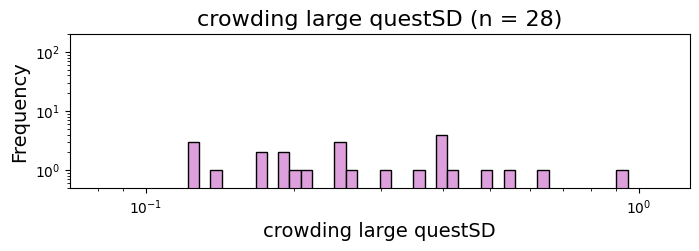

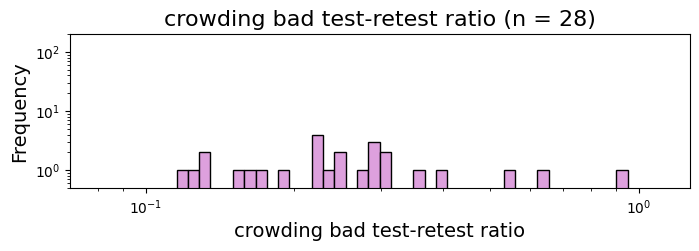

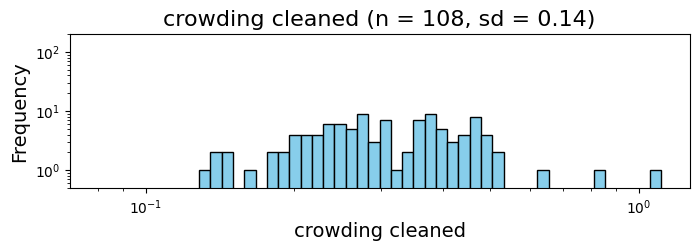

In [199]:
# crowding
plot_hist_task(df_gmean_task, 'crowding', 'gmean_threshold_task',
                crowding_low_trial_ids, crowding_large_questSD_ids, crowding_bad_ratio_ids, 
                bouma_bool=True)

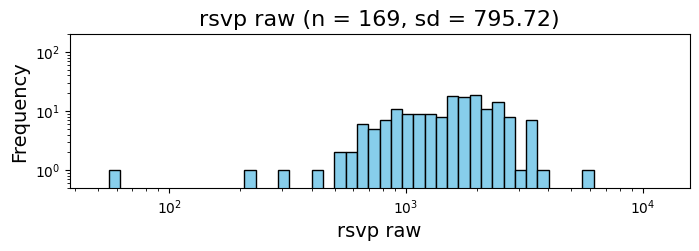

/var/folders/cw/__v4n9dd1cl59tk5n02vqjg5lj9bck/T/ipykernel_81560/3367854618.py:39: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


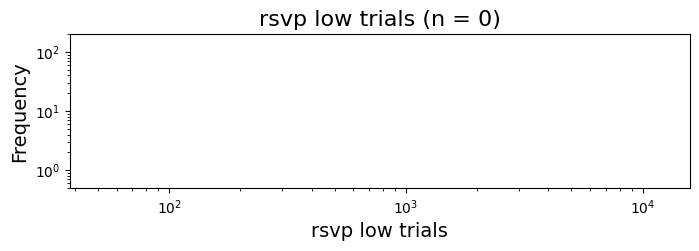

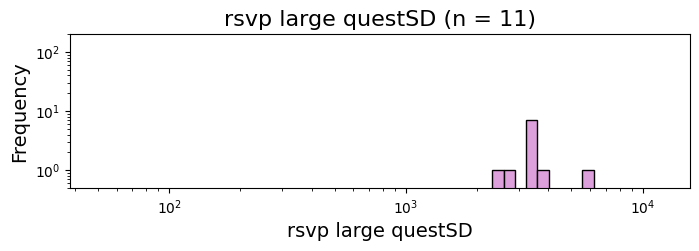

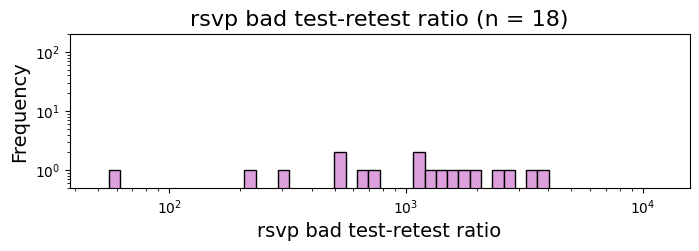

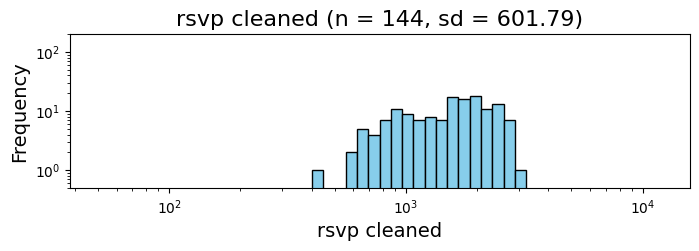

In [200]:
# rsvp
plot_hist_task(df_gmean_task, 'rsvp', 'gmean_threshold_task', 
                rsvp_low_trial_ids, rsvp_large_questSD_ids, rsvp_bad_ratio_ids, 
                num_bins=50, min_val=50, max_val=12000)

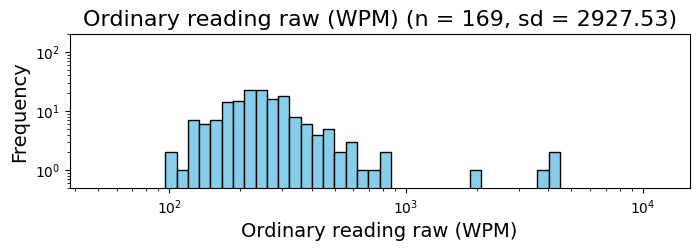

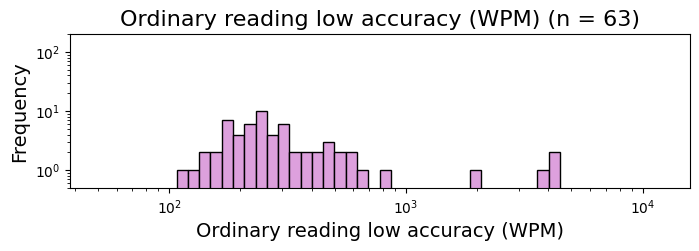

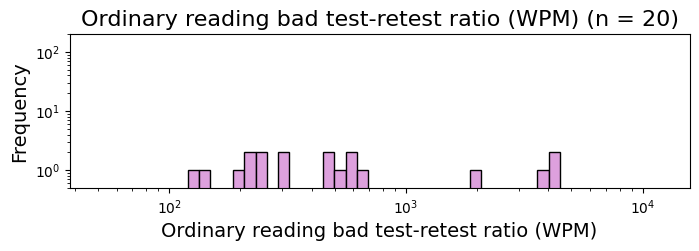

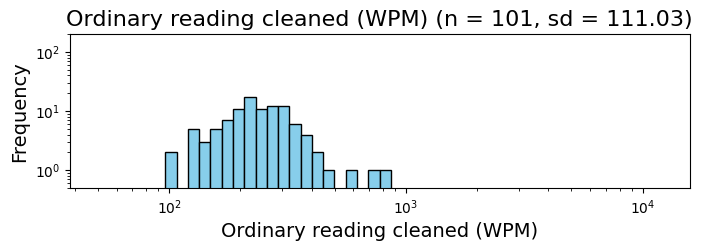

In [201]:
# ordinary reading
df_reading_gmean_task_raw = df_gmean_task[df_gmean_task['taskName'] == 'reading']
df_reading_gmean_task_low_trial = filter_including_ids(df_reading_gmean_task_raw, reading_low_accuracy_ids)
df_reading_gmean_task_bad_ratio = filter_including_ids(df_reading_gmean_task_raw, reading_bad_ratio_ids)
df_reading_gmean_task_cleaned = filter_excluding_ids(df_reading_gmean_task_raw, reading_low_accuracy_ids, reading_bad_ratio_ids)

plot_threshold_array(df_reading_gmean_task_raw['gmean_threshold_task'], 'Ordinary reading raw (WPM)', num_bins=50, min_val=50, max_val=12000)
plot_threshold_array(df_reading_gmean_task_low_trial['gmean_threshold_task'], 'Ordinary reading low accuracy (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_task_bad_ratio['gmean_threshold_task'], 'Ordinary reading bad test-retest ratio (WPM)', num_bins=50, min_val=50, max_val=12000, hist_color='plum', name_sd_bool=False)
plot_threshold_array(df_reading_gmean_task_cleaned['gmean_threshold_task'], 'Ordinary reading cleaned (WPM)', num_bins=50, min_val=50, max_val=12000)

# Analysis (outdated)
- note that everything in df_cleaned is not logged

In [42]:
df_for_analysis = df_cleaned.copy()

## Function

In [43]:
def plot_scatter_with_correlation(df, var_x, var_y, title, log_data_bool=True,
                                  plotXequalsY_bool=False, equal_axes_bool=True):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    df = df.copy()

    if log_data_bool:
        # Log-transform the data, avoiding log(0) or log(negative)
        df[var_x] = np.log10(df[var_x].replace(0, np.nan))
        df[var_y] = np.log10(df[var_y].replace(0, np.nan))
    
	# print out minimum and maximum values of the variables
    min_x = df[var_x].min()
    min_y = df[var_y].min()
    max_x = df[var_x].max()
    max_y = df[var_y].max()
    print(f'Min and max values: min_x: {min_x}, max_x: {max_x}, min_y: {min_y}, max_y: {max_y}')
    
    # Compute Pearson correlation
    valid = (~np.isnan(df[var_x])) & (~np.isnan(df[var_y]))
    r, p_value = stats.pearsonr(df[var_x][valid], df[var_y][valid])

    # Determine axis limits (same for both axes)
    min_val = min(df[var_x].min(), df[var_y].min())
    min_val = min_val - abs(min_val) * 0.2
    max_val = max(df[var_x].max(), df[var_y].max())
    max_val = max_val + abs(max_val) * 0.2


    # Create the scatter plot
    plt.figure(figsize=(4, 4))  
    sns.scatterplot(x=df[var_x], y=df[var_y], s=50)

    # plot x = y
    if plotXequalsY_bool:
            plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", linewidth=1.5)
            
    # Set limits for both axes to be the same
    if equal_axes_bool:
        plt.axis('equal')
        plt.gca().set_aspect('equal', adjustable='box')
        # plt.xlim(min_val, max_val)
        # plt.ylim(min_val, max_val)
    else:
        plt.gca().set_aspect('auto', adjustable='box')  


    # Add title with Pearson's r value
    plt.title(title + f"\n r = {r:.2f}", fontsize=16)
    
    # Add labels
    plt.xlabel(var_x, fontsize=14)
    plt.ylabel(var_y, fontsize=14)
    plt.xticks(fontsize=10)  
    plt.yticks(fontsize=10) 
    
        
    # Show plot
    plt.show()


## Test-retest

Min and max values: min_x: -0.28486264400000005, max_x: 0.8456866949999999, min_y: -0.28864219649999995, max_y: 0.901201004


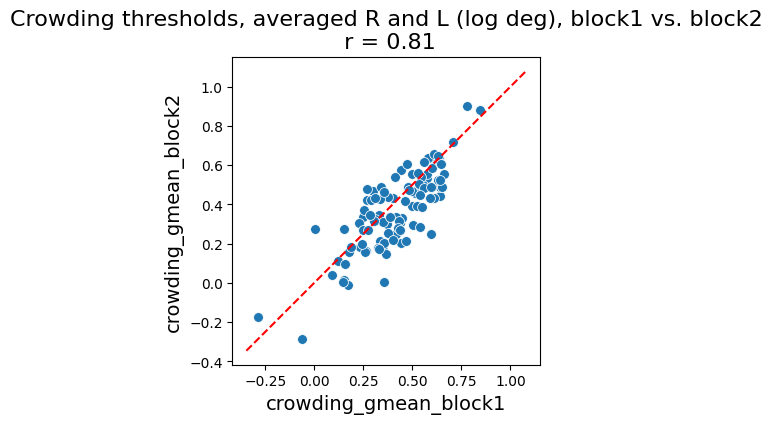

In [44]:
plot_scatter_with_correlation(df_for_analysis, "crowding_gmean_block1", "crowding_gmean_block2", 
                              'Crowding thresholds, averaged R and L (log deg), block1 vs. block2', plotXequalsY_bool=True)

Min and max values: min_x: -0.4322539585, max_x: 0.950354103, min_y: -0.40871242249999995, max_y: 1.04075982


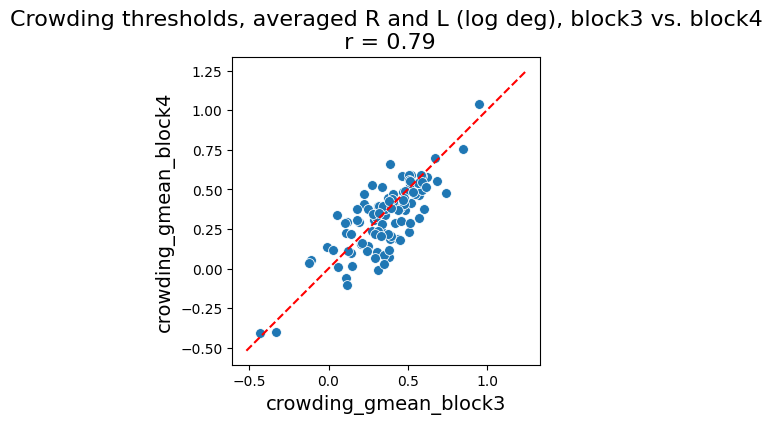

In [45]:
plot_scatter_with_correlation(df_for_analysis, "crowding_gmean_block3", "crowding_gmean_block4", 
                              'Crowding thresholds, averaged R and L (log deg), block3 vs. block4', plotXequalsY_bool=True)


Min and max values: min_x: -0.28486264400000005, max_x: 0.8456866949999999, min_y: -0.40871242249999995, max_y: 1.04075982


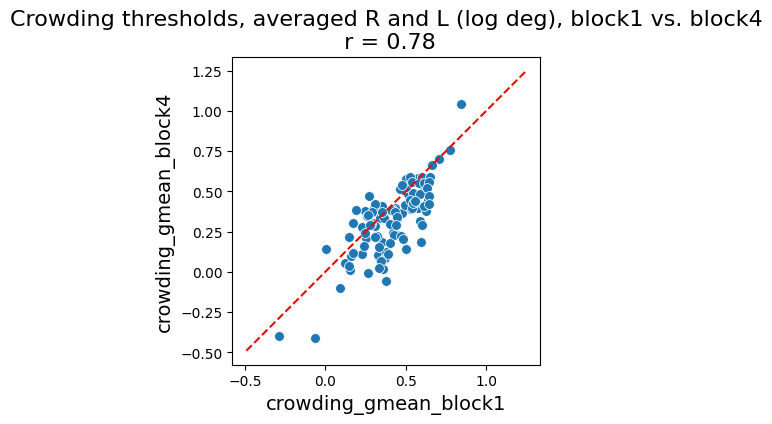

In [46]:
plot_scatter_with_correlation(df_for_analysis, "crowding_gmean_block1", "crowding_gmean_block4", 
                              'Crowding thresholds, averaged R and L (log deg), block1 vs. block4', plotXequalsY_bool=True)

Min and max values: min_x: -0.7324677135000001, max_x: -0.216273549, min_y: -0.778732197, max_y: -0.2847650095


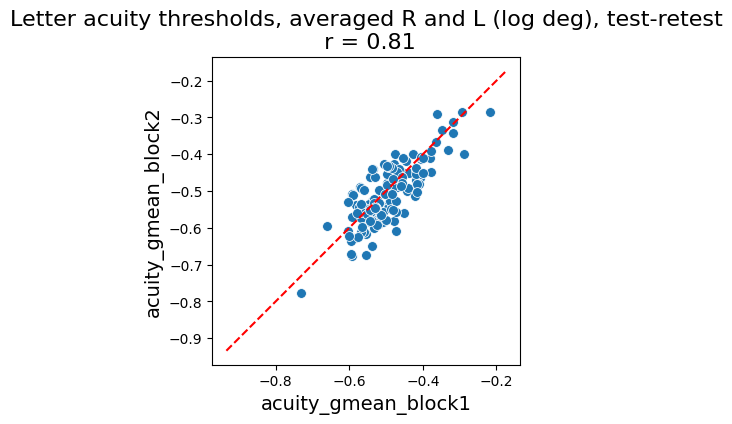

In [47]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_block1", "acuity_gmean_block2", 
                              'Letter acuity thresholds, averaged R and L (log deg), test-retest', plotXequalsY_bool=True)


Min and max values: min_x: 0.01970168789968353, max_x: 0.17970987247286835, min_y: 0.01970168789968353, max_y: 0.1273610550284859


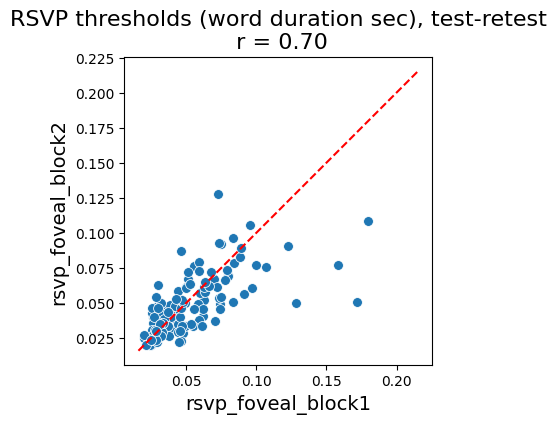

In [48]:
plot_scatter_with_correlation(df_for_analysis, "rsvp_foveal_block1", "rsvp_foveal_block2",
                                'RSVP thresholds (word duration sec), test-retest', log_data_bool=False, plotXequalsY_bool=True)


Min and max values: min_x: 2.0211946698989363, max_x: 2.8095027999307023, min_y: 2.0247515956919573, max_y: 2.7132561892007505


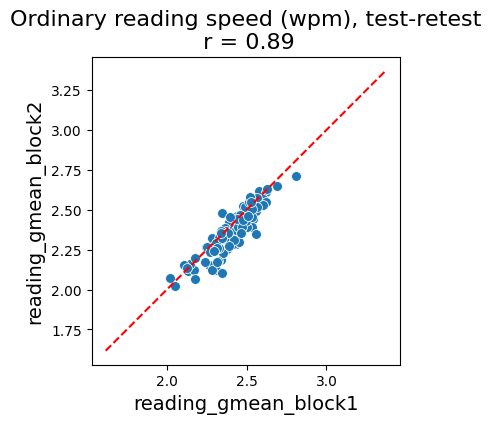

In [49]:
plot_scatter_with_correlation(df_for_analysis, "reading_gmean_block1", "reading_gmean_block2",
                                'Ordinary reading speed (wpm), test-retest', plotXequalsY_bool=True)

## Is there left-right asymmetry?

In [50]:
# plot_scatter_with_correlation(df_subj_avg, "crowding_R8", "crowding_L8", 
#                               'Crowding, right vs. left', plotXequalsY_bool=True)

In [51]:
# plot_scatter_with_correlation(df_subj_avg, "acuity_R8", "acuity_L8", 
#                               'Letter acuity, right vs. left', plotXequalsY_bool=True)

## Correlation between tasks

### Scatter plots with measured R

Min and max values: min_x: -1.6891992449999997, max_x: -0.8550828359999999, min_y: -0.29858858325, max_y: 0.929864890375


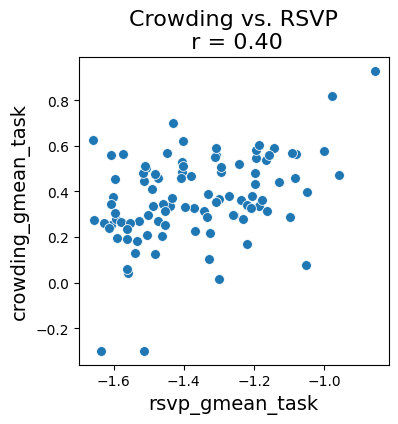

In [52]:
plot_scatter_with_correlation(df_for_analysis, "rsvp_gmean_task", "crowding_gmean_task", 
                              'Crowding vs. RSVP', equal_axes_bool=False)

Min and max values: min_x: 2.0391113692830287, max_x: 2.761379494565726, min_y: -0.29858858325, max_y: 0.929864890375


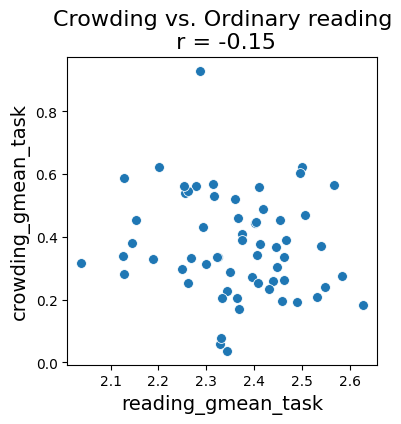

In [53]:
plot_scatter_with_correlation(df_for_analysis, "reading_gmean_task", "crowding_gmean_task", 
                              'Crowding vs. Ordinary reading', equal_axes_bool=False)

Min and max values: min_x: -0.75559995525, max_x: -0.25051927925, min_y: -0.29858858325, max_y: 0.929864890375


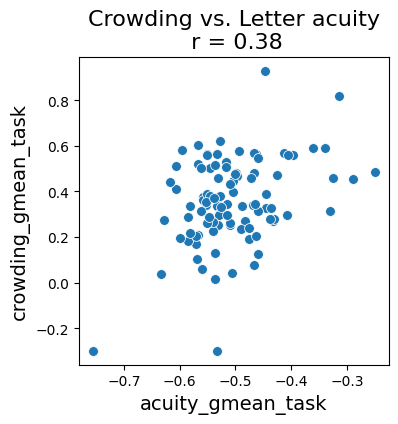

In [54]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_task", "crowding_gmean_task", 
                              'Crowding vs. Letter acuity', equal_axes_bool=False)

Min and max values: min_x: -0.75559995525, max_x: -0.25051927925, min_y: -1.6891992449999997, max_y: -0.8550828359999999


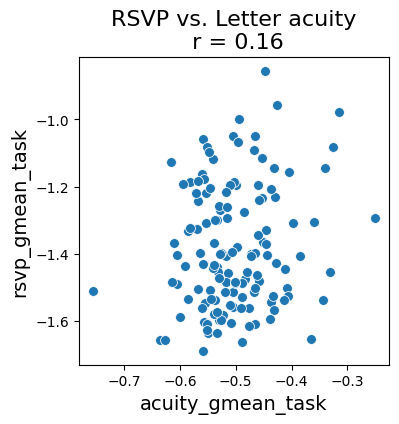

In [55]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_task", "rsvp_gmean_task", 
                              'RSVP vs. Letter acuity', equal_axes_bool=False)

Min and max values: min_x: -0.75559995525, max_x: -0.25051927925, min_y: 2.0391113692830287, max_y: 2.761379494565726


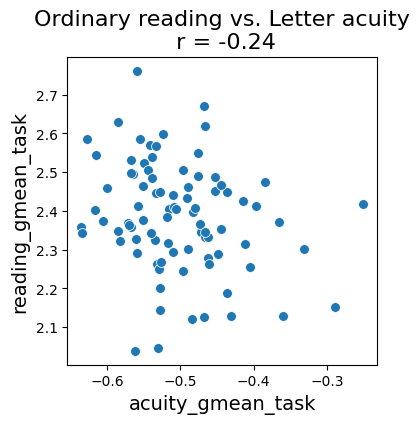

In [56]:
plot_scatter_with_correlation(df_for_analysis, "acuity_gmean_task", "reading_gmean_task", 
                              'Ordinary reading vs. Letter acuity', equal_axes_bool=False)

### Data frame with measured and corrected R (outdated)

In [57]:
def calc_within_subj_variance(df, task_prefix):
    """Calculate within-subject variance for all subjects for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Calculate variance for each subject (row) across repeats (columns)
    return df[task_cols].var(axis=1, ddof=1).mean()

def calc_between_subj_variance(df, task_prefix):
    """Calculate between-subject variance for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # Average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # Variance between subjects
    return np.nanvar(subj_means, ddof=1)

def calc_mean(df, task_prefix):
    """Calculate mean for all thresholds for a given task prefix."""
    task_cols = [col for col in df.columns if col.startswith(task_prefix)]
    # first average across repeats for each subject
    subj_means = df[task_cols].mean(axis=1)
    # then average across subjects
    return np.nanmean(subj_means)

def compute_noise_ceiling(df, task_prefix):
	"""
	Reference: Diedrichsen
	Computes the noise ceiling for a set of repeated measurements.
	Uses split-half reliability across multiple measurements and the geometric mean formula.
	"""
	task_cols = [col for col in df.columns if col.startswith(task_prefix)]
	measurements = df[task_cols]

	n_measurements = measurements.shape[1]
	
	first_half = measurements.iloc[:, :n_measurements//2]
	last_half = measurements.iloc[:, n_measurements//2:]
	odd_half = measurements.iloc[:, 1::2]
	even_half = measurements.iloc[:, 0::2]
	
	# Compute means while ignoring NaN
	mean_first_half = np.mean(first_half, axis=1)
	mean_last_half = np.mean(last_half, axis=1)

	# Filter out rows where either mean is NaN
	valid_indices = ~np.isnan(mean_first_half) & ~np.isnan(mean_last_half)

	# Compute Pearson correlation only for valid rows
	r_firstLast, _ = stats.pearsonr(mean_first_half[valid_indices], mean_last_half[valid_indices])

	# Repeat for odd/even halves
	mean_odd_half = np.mean(odd_half, axis=1)
	mean_even_half = np.mean(even_half, axis=1)

     
	valid_indices = ~np.isnan(mean_odd_half) & ~np.isnan(mean_even_half)
	r_oddEven, _ = stats.pearsonr(mean_odd_half[valid_indices], mean_even_half[valid_indices])
	
	# Compute the split-half reliability as the geometric mean
	r_i = np.sqrt(r_firstLast * r_oddEven)

	# Apply the extrapolation formula for multiple measurements
	N = 2
	r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

	return r_m


def gather_results(df, task_prefixes):
    """Gather results for within and between subject variance."""
    results = []
    for task in task_prefixes:

		
        within_var = calc_within_subj_variance(df, task)
        between_var = calc_between_subj_variance(df, task)
        mean_val = calc_mean(df, task)
        r_ceiling = compute_noise_ceiling(df, task)
        
        results.append({'task': task, 'within_subj_variance': within_var, 
                        'btw_subj_variance': between_var, 'mean': mean_val,
                        'r_ceiling': r_ceiling})
    return pd.DataFrame(results)

In [58]:
def print_measured_corrected_r(df, var_x, var_y, noise_ceiling_x, noise_ceiling_y):
    """
    Plots a scatter plot of two variables from a DataFrame and computes Pearson's r.
    
    Parameters:
        df (pd.DataFrame): The data frame containing the variables.
        var_x (str): Name of the first variable (x-axis).
        var_y (str): Name of the second variable (y-axis).
    """
    df = df.copy()
    
    
    # Compute Pearson correlation
    valid = (~np.isnan(df[var_x])) & (~np.isnan(df[var_y]))
    r_measured, p_value = stats.pearsonr(df[var_x][valid], df[var_y][valid])

    # correction
    noise_ceiling = np.sqrt(noise_ceiling_x * noise_ceiling_y)
    r_corrected = r_measured / noise_ceiling

    print(f"Correlating: {var_x} and {var_y}: Pearson's r (measured): {r_measured:.2f}, r (corrected): {r_corrected:.2f}")
    print(f"Noise ceilings: {var_x}: {noise_ceiling_x:.2f}; {var_y}: {noise_ceiling_y:.2f}; combined: {noise_ceiling:.2f}")

    df_corr_results = pd.DataFrame({
        'var_x': [var_x],
        'var_y': [var_y],
        'noise_ceiling_x': [noise_ceiling_x],
        'noise_ceiling_y': [noise_ceiling_y],
        'r_measured': [r_measured],
        'r_corrected': [r_corrected]
    })

    return df_corr_results

    



In [59]:
print(df_for_analysis.columns)

Index(['prolificID', 'crowding_R8_block1', 'crowding_L8_block1',
       'crowding_R8_block2', 'crowding_L8_block2', 'acuity_R8_block1',
       'acuity_L8_block1', 'rsvp_foveal_block1', 'reading_Beaver_block1',
       'reading_Winter_block2', 'crowding_R8_block3', 'crowding_L8_block3',
       'crowding_R8_block4', 'crowding_L8_block4', 'acuity_R8_block2',
       'acuity_L8_block2', 'rsvp_foveal_block2', 'reading_Desert_block1',
       'reading_Islands_block2', 'crowding_gmean_block1',
       'crowding_gmean_block2', 'crowding_gmean_block3',
       'crowding_gmean_block4', 'acuity_gmean_block1', 'acuity_gmean_block2',
       'reading_gmean_block1', 'reading_gmean_block2', 'acuity_gmean_task',
       'crowding_gmean_task', 'rsvp_gmean_task', 'reading_gmean_task',
       'acuity_ratio', 'rsvp_ratio', 'reading_ratio', 'crowding_ratio_12',
       'crowding_ratio_13', 'crowding_ratio_14', 'crowding_ratio_23',
       'crowding_ratio_24', 'crowding_ratio_34'],
      dtype='object')


In [60]:
col_for_variance = ['crowding_gmean_block1', 'crowding_gmean_block2', 'crowding_gmean_block3', 'crowding_gmean_block4',
                    'acuity_gmean_block1', 'acuity_gmean_block2',
                    'rsvp_foveal_block1', 'rsvp_foveal_block2',
                    'reading_gmean_block1', 'reading_gmean_block2']

df_for_variance_log = df_for_analysis[col_for_variance].copy()
numeric_cols = df_for_variance_log.select_dtypes(include=[np.number]).columns
df_for_variance_log[numeric_cols] = np.log10(df_for_variance_log[numeric_cols].where(df_for_variance_log[numeric_cols] > 0))


In [61]:
task_prefixes = ['crowding', 'acuity', 'rsvp', 'reading']
variance_df = gather_results(df_for_variance_log, task_prefixes)

In [62]:
display(variance_df)

,task,within_subj_variance,btw_subj_variance,mean,r_ceiling
0,crowding,0.009225,0.035786,0.372032,0.944642
1,acuity,0.001281,0.005503,-0.502393,0.892818
2,rsvp,0.009012,0.034427,-1.380738,0.873489
3,reading,0.003046,0.018934,2.380746,0.944208


In [63]:
# filepath = 'variance_df.csv'
# variance_df = pd.read_csv(filepath)
# display(variance_df)

In [64]:
col_for_corr = ['crowding_gmean_task', 'acuity_gmean_task', 'rsvp_gmean_task', 'reading_gmean_task']

df_for_corr_log = df_for_analysis[col_for_corr].copy()
numeric_cols = df_for_corr_log.select_dtypes(include=[np.number]).columns
df_for_corr_log[numeric_cols] = np.log10(df_for_corr_log[numeric_cols].where(df_for_corr_log[numeric_cols] > 0))


In [65]:
df_corr_results1 = print_measured_corrected_r(df_for_corr_log, 'crowding_gmean_task', 'rsvp_gmean_task', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'rsvp']['r_ceiling'].values[0])
df_corr_results2 = print_measured_corrected_r(df_for_corr_log, 'crowding_gmean_task', 'reading_gmean_task', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'reading']['r_ceiling'].values[0])
df_corr_results3 = print_measured_corrected_r(df_for_corr_log, 'crowding_gmean_task', 'acuity_gmean_task', 
                                                variance_df[variance_df['task'] == 'crowding']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0])
df_corr_results4 = print_measured_corrected_r(df_for_corr_log, 'acuity_gmean_task', 'rsvp_gmean_task', 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'rsvp']['r_ceiling'].values[0])
df_corr_results5 = print_measured_corrected_r(df_for_corr_log, 'acuity_gmean_task', 'reading_gmean_task', 
                                                variance_df[variance_df['task'] == 'acuity']['r_ceiling'].values[0], 
                                                variance_df[variance_df['task'] == 'reading']['r_ceiling'].values[0])

Correlating: crowding_gmean_task and rsvp_gmean_task: Pearson's r (measured): 0.40, r (corrected): 0.45
Noise ceilings: crowding_gmean_task: 0.94; rsvp_gmean_task: 0.87; combined: 0.91
Correlating: crowding_gmean_task and reading_gmean_task: Pearson's r (measured): -0.15, r (corrected): -0.16
Noise ceilings: crowding_gmean_task: 0.94; reading_gmean_task: 0.94; combined: 0.94
Correlating: crowding_gmean_task and acuity_gmean_task: Pearson's r (measured): 0.38, r (corrected): 0.42
Noise ceilings: crowding_gmean_task: 0.94; acuity_gmean_task: 0.89; combined: 0.92
Correlating: acuity_gmean_task and rsvp_gmean_task: Pearson's r (measured): 0.16, r (corrected): 0.18
Noise ceilings: acuity_gmean_task: 0.89; rsvp_gmean_task: 0.87; combined: 0.88
Correlating: acuity_gmean_task and reading_gmean_task: Pearson's r (measured): -0.24, r (corrected): -0.26
Noise ceilings: acuity_gmean_task: 0.89; reading_gmean_task: 0.94; combined: 0.92


In [66]:
df_corr_results = pd.concat([df_corr_results1, df_corr_results2, df_corr_results3, df_corr_results4, df_corr_results5], ignore_index=True)
display(df_corr_results)

,var_x,var_y,noise_ceiling_x,noise_ceiling_y,r_measured,r_corrected
0,crowding_gmean_task,rsvp_gmean_task,0.944642,0.873489,0.404429,0.445225
1,crowding_gmean_task,reading_gmean_task,0.944642,0.944208,-0.154328,-0.163410
2,crowding_gmean_task,acuity_gmean_task,0.944642,0.892818,0.382440,0.416436
3,acuity_gmean_task,rsvp_gmean_task,0.892818,0.873489,0.156524,0.177243
4,acuity_gmean_task,reading_gmean_task,0.892818,0.944208,-0.239632,-0.260993
